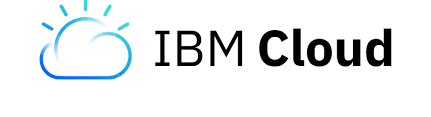

# CASE STUDY - topic modeling and feature engineering


[Feature engineering](https://en.wikipedia.org/wiki/Feature_engineering) is the process of using domain knowledge of your data to create features that can be leveraged by machine learning.  That is not a hard definition, because sometimes it is used in a context where features are transformed for machine learning, but the inclusion of domain knowledge is not implied.  

It is unfortunately common that for large datasets engineered features are not easy to create.  When there are many features generally only a small number play an important roll when it comes to prediction.  Furthermore,  domain insight is even more difficult to fold into the model when there are hundreds or thousands of features to keep in mind.  However, there is a middle ground---much of the worlds knowledge is locked up in language.  In this case study we will use topic modeling to gather insight from text.  Ideally, the result of these types of experiments would be shared with domain experts to further engineer features that are relevant when it comes to your business opportunity.

In [2]:
!pip install pyLDAvis


In [3]:
import pyLDAvis
import pyLDAvis.lda_model  # ✅ Correct module for version 3.4.0
print("pyLDAvis version:", pyLDAvis.__version__)


pyLDAvis version: 3.4.0


In [4]:
pip install seaborn


Note: you may need to restart the kernel to use updated packages.


In [5]:
import seaborn as sns
print("Seaborn is installed correctly!")


Seaborn is installed correctly!


In [6]:
import os
import re
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # ✅ Ensure Seaborn is imported

from sklearn.utils import shuffle
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from string import punctuation, printable
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

try:
    import pyLDAvis
    import pyLDAvis.lda_model  # ✅ Use correct module for version 3.4.0
except:
    raise Exception("'pip install pyldavis' before running this notebook")

pyLDAvis.enable_notebook()

# ✅ Fix: Use Seaborn styling if available
sns.set_style("darkgrid")  

# ✅ Alternative: Use a built-in Matplotlib style
# plt.style.use('ggplot')

%matplotlib inline

DATA_DIR = os.path.join("..", "data")  # ✅ Correct path formatting


## Synopsis

   >Goal:  AAVAIL has recently enabled comments on the core streaming service.  The data science team knows that   this will be an incredibly important source of data going forward.  It will be used inform customer retention, product quality, product market fit and more.  Comments are going live next week and being the diligent data scientist that you are your plan is to build a topic modeling pipeline that will consume the comments and create visualizations that can be used to communicate with domain experts.
  
## Outline

1. EDA - summary tables, use tSNE to visualize the data
2. Create a transfomation pipelines for NMF and LDA
3. Use ldaviz and wordclouds to get insight into the clusters

## Data

Even before receiving the first comment, we want to start building our Pipeline using a proxy dataset. In this study Case we will work with a dataset publicly available dataset of movie reviews.

* [Here](http://www.nltk.org/nltk_data) is the web page that references all the public dataset that NLTK provide. In this Study Case we will work with the 'Sentiment Polarity Dataset Version 2.0' dataset. (The dataset has already been downloaded and is in the data folder of the working directory)
* For more examples of applications with these data see [NLTK's book chapter that uses these data](https://www.nltk.org/book/ch06.html)

In [7]:
import pandas as pd

# Define the correct path to your dataset
file_path = r"D:\Career\Enterprise workflow\Topic-Modeling-Case-Study-Local\data\movie_reviews\movie_reviews.csv"

# Load dataset
df = pd.read_csv(file_path)

# Display dataset info
print(df.info())

# Show first few rows
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  2000 non-null   object
 1   target  2000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.4+ KB
None
                                              review  target
0  b"arnold schwarzenegger has been an icon for a...       0
1  b"good films are hard to find these days . \ng...       1
2  b"quaid stars as a man who has taken up the pr...       1
3  b'we could paraphrase michelle pfieffer\'s cha...       0
4  b"kolya is one of the richest films i've seen ...       1


In [8]:
print(df.columns)


Index(['review', 'target'], dtype='object')


In [9]:
X = df["review"]  # Text reviews
y = df["target"]  # Sentiment labels (0 = Negative, 1 = Positive)

# Print a sample review
print("Sample Review:\n", X[4])
print("Sentiment Label:", y[4])


Sample Review:
 b"kolya is one of the richest films i've seen in some time . \nzdenek sverak plays a confirmed old bachelor ( who's likely to remain so ) , who finds his life as a czech cellist increasingly impacted by the five-year old boy that he's taking care of . \nthough it ends rather abruptly-- and i'm whining , 'cause i wanted to spend more time with these characters-- the acting , writing , and production values are as high as , if not higher than , comparable american dramas . \nthis father-and-son delight-- sverak also wrote the script , while his son , jan , directed-- won a golden globe for best foreign language film and , a couple days after i saw it , walked away an oscar . \nin czech and russian , with english subtitles . \n"
Sentiment Label: 1


In [10]:
print(df.isnull().sum())  # Check for missing values


review    0
target    0
dtype: int64


### QUESTION 1

The main focus of this exercise is to enable visualization of topics, but these topics can be used as additional 
features for prediction tasks.  The goal of this case study is to ensure that you are comfortable with natural language processing pipelines and topic modeling tools. 

There are many ways to process tokens (words, dates, emojis etc).  NLTK is often used to pre-process text data before the tokens are vectorized.  Generally, the tokens are modified via [stemming or lemmatization](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html).  The next code block provides a lemmatization function that makes use of the library [spacy](https://spacy.io/).  You will need to install it and download the English language reference material as follows.  Stopwords are words that are very common or otherwise irrelevant we use a default list here, but it is an important part of NLP pipelines that needs to be customized for the subject area. Use the following function to process the corpus (this can take a few minutes)

```bash
~$ pip install spacy
~$ python -m spacy download en
```

If you prefer to use NLTK then you could use a simple lemmatizer like the WordLemmatizer.

In [11]:
!pip install spacy


In [12]:
import spacy
nlp = spacy.load("en_core_web_sm")  # Loads the language model


In [ ]:
import spacy

# Load English NLP model
nlp = spacy.load("en_core_web_sm")
print("spaCy is working correctly!")


In [13]:
import spacy
STOPLIST = ENGLISH_STOP_WORDS
STOPLIST = set(list(STOPLIST) + ["foo", "film", "movie", "make"])

if not 'nlp' in locals():
    print("Loading English Module...")
    nlp = spacy.load('en_core_web_sm')

def lemmatize_document(doc, stop_words=None):
    """
    takes a list of strings where each string is a document
    returns a processed list of strings
    """
    
    if not stop_words:
        stop_words = set([])
  
    ## ensure working with string
    doc = str(doc)
    doc = doc.replace('\\n','')
    doc = doc.replace('\\t','')

    # First remove punctuation form string
    if sys.version_info.major == 3:
        PUNCT_DICT = {ord(punc): None for punc in punctuation}
        doc = doc.translate(PUNCT_DICT)

    # remove unicode
    clean_doc = "".join([char for char in doc if char in printable])
            
    # Run the doc through spaCy
    doc = nlp(clean_doc)

    # Lemmatize and lower text
    tokens = [re.sub(r"\W+","",token.lemma_.lower()) for token in doc ]
    tokens = [t for t in tokens if len(t) > 1]
    
    return ' '.join(w for w in tokens if w not in stop_words)    

## example usage
corpus = ['"You can fool some of the people all of the time, and all of the people some of the time, but you can not fool all of the people all of the time". -- Abraham Lincoln']
processed = [lemmatize_document(doc, STOPLIST) for doc in corpus]
print(processed[0])
processed = [lemmatize_document(doc, None) for doc in corpus]
print("\n"+processed[0])

fool people time people time fool people time abraham lincoln

you can fool some of the people all of the time and all of the people some of the time but you can not fool all of the people all of the time abraham lincoln


In [ ]:
## YOUR CODE HERE

## Preprocess all the reviews of the corpus with the lemmatize_document() 
## function to create a list of cleaned reviews.
processed = 
print("processing done.")

In [15]:
# Decode byte strings to normal text
X_decoded = [review.decode("utf-8") if isinstance(review, bytes) else review for review in df["review"]]

# Print a sample review
print("Sample Review:\n", X_decoded[0])


Sample Review:
 b"arnold schwarzenegger has been an icon for action enthusiasts , since the late 80's , but lately his films have been very sloppy and the one-liners are getting worse . \nit's hard seeing arnold as mr . freeze in batman and robin , especially when he says tons of ice jokes , but hey he got 15 million , what's it matter to him ? \nonce again arnold has signed to do another expensive blockbuster , that can't compare with the likes of the terminator series , true lies and even eraser . \nin this so called dark thriller , the devil ( gabriel byrne ) has come upon earth , to impregnate a woman ( robin tunney ) which happens every 1000 years , and basically destroy the world , but apparently god has chosen one man , and that one man is jericho cane ( arnold himself ) . \nwith the help of a trusty sidekick ( kevin pollack ) , they will stop at nothing to let the devil take over the world ! \nparts of this are actually so absurd , that they would fit right in with dogma . \nye

In [16]:
# Convert byte string to normal string
sample_review = X_decoded[0].decode("utf-8") if isinstance(X_decoded[0], bytes) else X_decoded[0]

# Print the cleaned sample review
print("Decoded Review:\n", sample_review)


Decoded Review:
 b"arnold schwarzenegger has been an icon for action enthusiasts , since the late 80's , but lately his films have been very sloppy and the one-liners are getting worse . \nit's hard seeing arnold as mr . freeze in batman and robin , especially when he says tons of ice jokes , but hey he got 15 million , what's it matter to him ? \nonce again arnold has signed to do another expensive blockbuster , that can't compare with the likes of the terminator series , true lies and even eraser . \nin this so called dark thriller , the devil ( gabriel byrne ) has come upon earth , to impregnate a woman ( robin tunney ) which happens every 1000 years , and basically destroy the world , but apparently god has chosen one man , and that one man is jericho cane ( arnold himself ) . \nwith the help of a trusty sidekick ( kevin pollack ) , they will stop at nothing to let the devil take over the world ! \nparts of this are actually so absurd , that they would fit right in with dogma . \ny

In [18]:
# Apply lemmatization to the sample review
lemmatized_review = lemmatize_document(sample_review)

# Print the cleaned review
print("\nLemmatized Review:\n", lemmatized_review)



Lemmatized Review:
 barnold schwarzenegg have be an icon for action enthusiast since the late 80 but lately his film have be very sloppy and the oneliner be get bad its hard seeing arnold as mr freeze in batman and robin especially when he say ton of ice joke but hey he get 15 million what it matter to he once again arnold have sign to do another expensive blockbuster that can not compare with the like of the terminator series true lie and even eraser in this so call dark thriller the devil gabriel byrne have come upon earth to impregnate woman robin tunney which happen every 1000 year and basically destroy the world but apparently god have choose one man and that one man be jericho cane arnold himself with the help of trusty sidekick kevin pollack they will stop at nothing to let the devil take over the world part of this be actually so absurd that they would fit right in with dogma yes the film be that weak but its well than the other blockbuster right now sleepy hollow but it make 

In [22]:
# Decode and preprocess all reviews
processed = [lemmatize_document(review.decode("utf-8") if isinstance(review, bytes) else review) for review in X_decoded]

print("Processing done.")


Processing done.


### QUESTION 2

Use the CountVectorizer from sklearn to vectorize the documents.

Additional resources:

* [scikit-learn CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
* [scikit-learn working with text](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)

Because this is an exercise in visualization set the `max_features` to something like 500.  In the context of supervised learning it is reasonable to grid-search to optimize this parameter.

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

# Set max_features as required
max_features = 500  

# Create a CountVectorizer object with stopword removal
tf_vectorizer = CountVectorizer(max_features=max_features, stop_words="english")

# Fit and transform the processed reviews into a document-term matrix
tf = tf_vectorizer.fit_transform(processed)

print("ready")


ready


In [24]:
# Print the shape of the vectorized matrix
print(f"Vectorized Matrix Shape: {tf.shape}")  # (num_documents, num_features)

# Print the first 20 feature words
print("Sample Features:\n", tf_vectorizer.get_feature_names_out()[:20])


Vectorized Matrix Shape: (2000, 500)
Sample Features:
 ['able' 'act' 'acting' 'action' 'actor' 'actress' 'actually' 'add' 'age'
 'agent' 'ago' 'alien' 'allow' 'america' 'american' 'apparently' 'appear'
 'approach' 'art' 'ask']


In [ ]:
## YOUR CODE HERE

max_features = 500

# Create a CountVectorizer object
tf_vectorizer = 

# Fit and transform this object to the processed reviews
tf = 
print("ready")

### QUESTION 3

Fit a LDA model to the corpus. For example, you could use something like the following.

```python
n_topics = 10
lda_model = LatentDirichletAllocation(n_components=n_topics, max_iter=5,
                                      learning_method='online',
                                      learning_offset=50.,
                                      random_state=0)

lda_model.fit(tf)
```


* [scikit-learn's LDA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html)
* [scikit-learn's user guide for LDA](https://scikit-learn.org/stable/modules/decomposition.html#latentdirichletallocation)

In [25]:
from sklearn.decomposition import LatentDirichletAllocation

# Define number of topics
n_topics = 10  

# Create an LDA object
lda_model = LatentDirichletAllocation(
    n_components=n_topics,  # Number of topics
    max_iter=5,             # Number of iterations
    learning_method='online',  # Online learning for batch updates
    learning_offset=50.0,      # Helps improve stability
    random_state=0             # For reproducibility
)

# Fit the model to the bag-of-words matrix
lda_model.fit(tf)  # `tf` is the CountVectorizer output

print("LDA Model Training Completed.")


LDA Model Training Completed.


In [26]:
def display_topics(model, feature_names, num_words=10):
    """Prints top words for each topic"""
    for topic_idx, topic in enumerate(model.components_):
        print(f"\nTopic {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-num_words - 1:-1]]))

# Display topics
display_topics(lda_model, tf_vectorizer.get_feature_names_out(), num_words=10)



Topic 1:
film like movie time end just good life novel make

Topic 2:
family film movie child disney black young vampire king man

Topic 3:
beautiful life heart short love movie woman guy son big

Topic 4:
wild smith kevin dog sex book man film comic movie

Topic 5:
film character make story scene like good man play time

Topic 6:
scream horror killer movie murder film know death summer genre

Topic 7:
film alien make series original character good scene like time

Topic 8:
film movie effect make just like character special good star

Topic 9:
movie like film good bad just make character time scene

Topic 10:
film movie like city new make life world girl joe


## QUESTION 4

Visualize the corpus using [pyldavis](https://github.com/bmabey/pyLDAvis).

```python
pyLDAvis.sklearn.prepare(lda_model,tf, tf_vectorizer, R=20)
```

* [PyLDAViz documentation](https://pyldavis.readthedocs.io/en/latest)
* [PyLDAViz demos](https://pyldavis.readthedocs.io/en/latest/readme.html#video-demos)

In [28]:
!pip install pyLDAvis --upgrade


In [29]:
import pyLDAvis
import pyLDAvis.lda_model  # Use 'lda_model' instead of 'sklearn'

# Enable visualization
pyLDAvis.enable_notebook()


In [30]:
# Prepare the LDA visualization
lda_vis = pyLDAvis.lda_model.prepare(lda_model, tf, tf_vectorizer, R=20)

# Display the interactive visualization
pyLDAvis.display(lda_vis)


## QUESTION 5

Try different numbers of clusters until there is decent separation in the visualization

In [34]:
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.lda_model

# Set the number of topics
n_topics = 7

# Create the LDA model
lda_model = LatentDirichletAllocation(
    n_components=n_topics, 
    max_iter=5, 
    learning_method='online',
    learning_offset=50.0,
    random_state=0
)

# Fit and transform the LDA model to the vectorized corpus
lda_transformed = lda_model.fit_transform(tf)  # `tf` is the CountVectorizer matrix

print("LDA Model Trained with 7 Topics.")


LDA Model Trained with 7 Topics.


In [35]:
# Prepare the LDA visualization
lda_vis = pyLDAvis.lda_model.prepare(lda_model, tf, tf_vectorizer, R=20)

# Display the visualization
pyLDAvis.display(lda_vis)


The visualization here can help determine a reasonable number of number of clusters and it can serve as a communication tool.  If the goal was to find topics that are associated with customer profiles then you would likely work with folks in marketing to refine the clustering.  There are a couple of parameters than can be used to modify the clustering and visualization.  The discovery of meaningful topics is a form of feature engineering.

## QUESTION 6

If you were to use the topics from this model to inform clustering or supervised learning you would first need to be able to extract and represent them as a matrix.  Along the same lines if you were to populate a report with tabular descriptions of the data then you will need to be able to extract topic representations.  Here is a starter function

In [36]:
def get_top_words(model, feature_names, n_top_words):
    """
    Get the top words defining the different topics of the LDA model
    INPUT : the LDA model, the names of the features of the bag of word (these are the actual words in the vocabulary) 
    and the number of top words.
    RETURN : A dictionary where the keys are the topic's ID and the values are the lists of the n_top_words top words.
    
    """
    top_words = {}
    for topic_idx, topic in enumerate(model.components_):
        _top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        top_words[str(topic_idx)] = _top_words
    return top_words

Use the function to print the top k words for each topic

In [37]:
## Set the number of top words per topic
n_top_words = 15  

## Get the vectorizer's feature names (actual words)
tf_feature_names = tf_vectorizer.get_feature_names_out()

## Get the top words for each topic
top_words = get_top_words(lda_model, tf_feature_names, n_top_words)

## Print the topics and the top words of each topic
for topic, words in top_words.items():
    print(f"\nTopic {topic}: {', '.join(words)}")



Topic 0: film, alien, effect, movie, star, make, special, like, time, good, human, war, earth, series, planet

Topic 1: movie, like, film, just, make, time, know, say, people, good, think, bad, way, thing, man

Topic 2: horror, scream, film, vampire, killer, sequel, original, movie, evil, murder, dr, know, make, summer, character

Topic 3: comedy, movie, funny, laugh, make, film, character, good, joke, just, like, time, play, humor, big

Topic 4: film, character, make, story, life, like, scene, good, man, time, play, work, movie, love, come

Topic 5: family, disney, voice, kid, song, film, child, story, little, boy, feature, young, make, like, music

Topic 6: film, movie, like, good, make, bad, character, just, scene, time, play, really, action, look, know


## QUESTION (EXTRA CREDIT) 7

If you used `transform` on your original tokens you should have a `2000 x k` array where `k` is the number of topics you choose.  Create a PCA or tSNE visualization that projects this matrix into lower dimensional space then uses colors to indicate which documents belong to a topic (e.g. probability > 0.5).

In [50]:
# Transform the reviews to get topic probability distributions
topic_matrix = lda_model.transform(tf)  # Shape: (2000, n_topics)

# Convert to a DataFrame
df_topics = pd.DataFrame(topic_matrix, columns=[f"Topic_{i}" for i in range(n_topics)])

# Display the first few rows
df_topics.head()


,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6
0,0.232310,0.001096,0.001094,0.001096,0.001096,0.001094,0.762214
1,0.001130,0.001129,0.001128,0.001130,0.993223,0.001128,0.001131
2,0.002174,0.237926,0.002169,0.654052,0.099324,0.002179,0.002175
3,0.002077,0.002081,0.002079,0.002079,0.641372,0.002080,0.348233
4,0.003980,0.003984,0.003980,0.003986,0.976098,0.003986,0.003987


In [51]:
# Convert LDA topic matrix into a DataFrame
df_topics = pd.DataFrame(topic_matrix, columns=[f"Topic_{i}" for i in range(n_topics)])

# Assign dominant topic based on highest probability
df_topics['Dominant_Topic'] = df_topics.idxmax(axis=1)

# Display sample of topic distribution
df_topics.head()


,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Dominant_Topic
0,0.232310,0.001096,0.001094,0.001096,0.001096,0.001094,0.762214,Topic_6
1,0.001130,0.001129,0.001128,0.001130,0.993223,0.001128,0.001131,Topic_4
2,0.002174,0.237926,0.002169,0.654052,0.099324,0.002179,0.002175,Topic_3
3,0.002077,0.002081,0.002079,0.002079,0.641372,0.002080,0.348233,Topic_4
4,0.003980,0.003984,0.003980,0.003986,0.976098,0.003986,0.003987,Topic_4


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

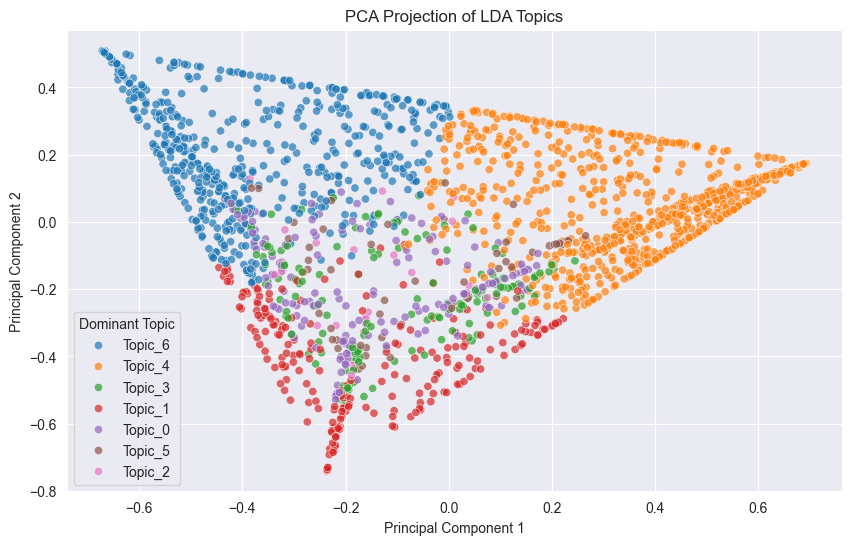

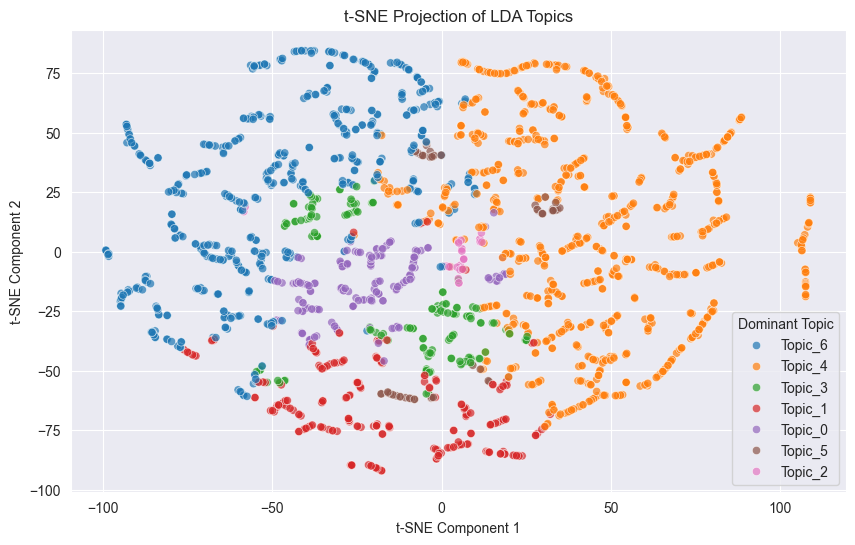

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Reduce topic distributions to 2D using PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_topics.iloc[:, :-1])  # Exclude 'Dominant_Topic' column

# Convert PCA results into DataFrame
df_pca = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
df_pca['Dominant_Topic'] = df_topics['Dominant_Topic']

# Plot PCA results
plt.figure(figsize=(10,6))
sns.scatterplot(x="PCA1", y="PCA2", hue="Dominant_Topic", palette="tab10", alpha=0.7, data=df_pca)
plt.title("PCA Projection of LDA Topics")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Dominant Topic")
plt.show()

# Reduce topic distributions to 2D using t-SNE
tsne = TSNE(n_components=2, perplexity=5, random_state=0)
tsne_result = tsne.fit_transform(df_topics.iloc[:, :-1])  # Exclude 'Dominant_Topic' column

# Convert t-SNE results into DataFrame
df_tsne = pd.DataFrame(tsne_result, columns=['tSNE1', 'tSNE2'])
df_tsne['Dominant_Topic'] = df_topics['Dominant_Topic']

# Plot t-SNE results
plt.figure(figsize=(10,6))
sns.scatterplot(x="tSNE1", y="tSNE2", hue="Dominant_Topic", palette="tab10", alpha=0.7, data=df_tsne)
plt.title("t-SNE Projection of LDA Topics")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Dominant Topic")
plt.show()
